# Energy Point Selection

This notebook demonstrates how to seleect energy points that most identify Reference spectra.

In [58]:
import selector
from selector import energy_point_selector

from sklearn.decomposition import PCA
from scipy.interpolate import interp1d, UnivariateSpline

import utils
from importlib import reload

# to reload utils, run:
utils = reload(utils)
from utils import *

# Load Reference Data
Read in example XANES spectra in `Data` folder.

In [37]:
df = parse_file('Data/As_exp_standards_normalized.dat')
df.head()

,X1,As 0109 (ASU standard),X2,As 0110 (ASU standard),X3,As2O3 0111 (ASU standard),X4,As2O3 0112 (ASU standard),X5,exp As (FL database),X6,exp As2O3 (XAFS Lib),X7,exp As2O5 (XAFS Lib)
0,11856.61600,0.016637180,11856.61600,0.000198142,11856.61600,0.001418308,11856.61600,0.009778866,11856.61600,0.004694093,11856.61600,0.006694889,11856.61600,0.000443824
1,11858.33300,-0.002795367,11858.33300,-0.000415112,11858.33300,-0.002971391,11858.33300,-0.005191439,11858.33300,-0.005053518,11858.33300,0.000622711,11858.33300,-0.000510835
2,11859.90100,-0.015086464,11859.90100,0.000216970,11859.90100,0.001553083,11859.90100,-0.011306886,11859.90100,-0.004923296,11859.90100,-0.001310810,11859.90100,-0.000395970
3,11861.32000,-0.016196060,11861.32000,0.012599321,11861.32000,0.008951790,11861.32000,-0.004657301,11861.32000,0.005282721,11861.32000,0.000688098,11861.32000,0.000462982
4,11862.59000,-0.006089772,11862.59000,0.027647458,11862.59000,0.031148090,11862.59000,0.011376760,11862.59000,0.032175104,11862.59000,0.008453673,11862.59000,0.002340333


In [137]:
# Energy = np.array(df['energy'], dtype=float)
# Refs = np.array(df.iloc[:, 1:], dtype=float).T
Energy = np.array(df['X1'], dtype=float)
data_columns = [colm for colm in df.columns if len(colm.replace('X', '')) != 1]
Refs = np.array(df[data_columns], dtype=float).T

Visualize reference spectra

In [138]:
def get_delta_E(energy, ref, set_whiteline=11865):
    """Get delta E from set whiteline."""
    interpolator = UnivariateSpline(energy, np.array(ref) - 0.5, s=0)
    whiteline = interpolator.roots()[0]
    delta_E = set_whiteline - whiteline
    return delta_E

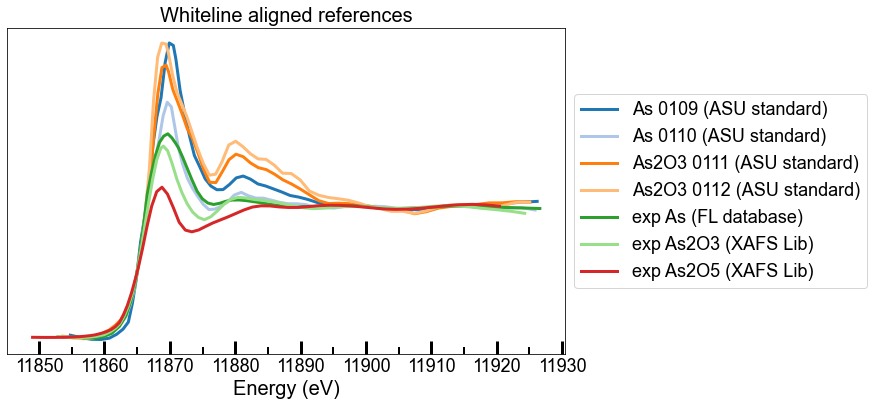

In [139]:
fig, ax = plt.subplots(figsize=(10, 6))
delta_Es = []
align_whiteline = True
for i, ref in enumerate(Refs):
    energy = np.array(df[f'X{i + 1}'], dtype=float)
    if align_whiteline:
        delta_E = get_delta_E(energy, ref)
        delta_Es.append(delta_E)
        ax.plot(e + delta_E, ref, '-', linewidth=3, c=plt.cm.tab20(i), label=data_columns[i])
    else:
        ax.plot(Energy, ref, '-', linewidth=3, c=plt.cm.tab20(i), label=data_columns[i])

ax.legend(fontsize=18, loc='center left', bbox_to_anchor=(1., .5))
if not align_whiteline:
#     plt.plot(Energy, np.ones(len(Energy))*0.5, 'k--', linewidth=2)
#     plt.plot(Energy, np.ones(len(Energy)), 'k--', linewidth=2)
    plt.title("Just normalized references", fontsize=20)
else:
    plt.title("Whiteline aligned references", fontsize=20)
format_axis(ax)
plt.show()

In [140]:
if align_whiteline:
    mn, mx = min(delta_Es), max(delta_Es)
    erange = Energy[0] - mx, Energy[-1] + mn
    Energy = np.linspace(erange[0], erange[1], 70)
    Aligned_Refs = []

    for i, ref in enumerate(Refs):
        energy = np.array(df[f'X{i + 1}'], dtype=float) + delta_Es[i]
        interpolator = interp1d(energy, np.array(ref))
        aligned = interpolator(Energy)
        Aligned_Refs.append(aligned)

    Aligned_Refs = np.array(Aligned_Refs)
else:
    Aligned_Refs = Refs

# PCA Analysis

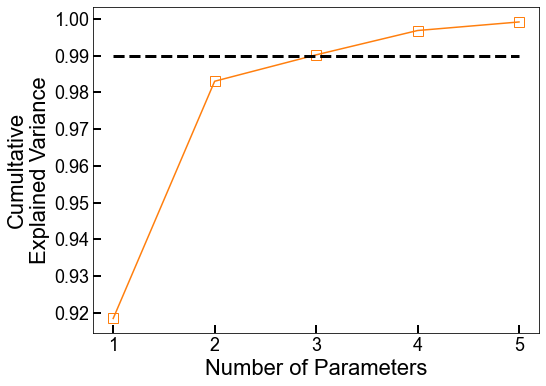

In [141]:
fig, ax = plt.subplots(figsize=(8,6))

pca = PCA()
pca_components = pca.fit_transform(Aligned_Refs)

n = 5
x = np.arange(n) + 1
cdf = [np.sum(pca.explained_variance_ratio_[:i + 1]) for i in range(n)]

ax.plot(x, cdf, 's-', markersize=10, fillstyle='none',
        color=plt.cm.tab10(.15))
ax.plot(x, np.ones(len(x)) * 0.99, 'k--', linewidth=3)

plt.xticks(x, fontsize=18)
plt.yticks(fontsize=18)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.xlabel('Number of Parameters', fontsize=22)
plt.ylabel(f'Cumultative\nExplained Variance', fontsize=22)
ax.tick_params(direction='in', width=2, length=8)
plt.show()

# Generate dataset

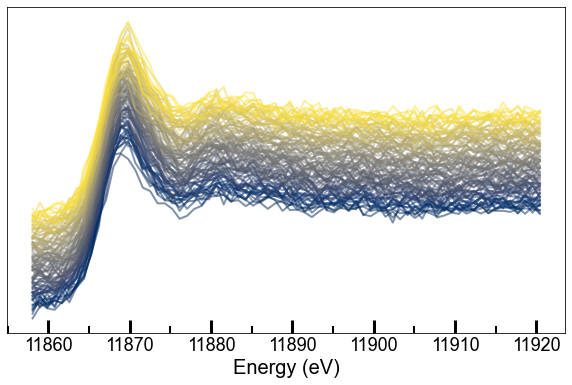

In [152]:
N = 100
data, coeffs = generate_linear_combos(Aligned_Refs, N=N, scale=0.05)

fig, ax = plt.subplots(figsize=(10, 6))
for i, spectrum in enumerate(data):
    ax.plot(Energy, spectrum + i*0.01, '-', linewidth=2, c=plt.cm.cividis(i/N), alpha=0.5)
format_axis(ax)
plt.show()

# Initialize Selector and perform selection algorithm

### Some difficulties:

1. Logistic regression and xgboost are models with feature importances that will work if the labels were one dimensional. A work around is using a RegressorChain or MultiOutputRegressor wrapper model.

2. Gaussian processes and other nonlinear models would work if permutation_importance worked as the importance_getter

e.g.

` def importance(model):`
    
 &emsp; &emsp; ` return permutation_importance(model, data, coeffs, scoring='neg_mean_squared_error')`
    
` importance_getter = importance`

All of these features are proving difficult to implement.

In [153]:
energy_point_selector = reload(selector.energy_point_selector)
select = energy_point_selector.Selector(data, coeffs)

For a list of possible scoring criteria, see `sklearn.metrics.SCORERS.keys()`

In [154]:
models = ['Linear Regression', 'Decision Tree', 'Random Forest']
n_points = [4, 5, 6, 7]
Scores = []
Epts = []

for npts in n_points:
    print(f'\nNum points: {npts}\n-----------------------')
    scores = []
    epts = []
    for model in models:
        print(f'\n{model}:')
        select = energy_point_selector.Selector(data, coeffs)
        rfe, score = select.select_energy_points(estimator=model, n_points=npts,
                                                 scoring='neg_root_mean_squared_error')
        energy_points = Energy[rfe.support_]
        epts.append(energy_points)
        scores.append(score)
    Scores.append(scores)
    Epts.append(epts)


Num points: 4
-----------------------

Linear Regression:
Score: -0.135 (0.016)

Decision Tree:
Score: -0.100 (0.009)

Random Forest:
Score: -0.071 (0.008)

Num points: 5
-----------------------

Linear Regression:
Score: -0.135 (0.016)

Decision Tree:
Score: -0.100 (0.009)

Random Forest:
Score: -0.071 (0.008)

Num points: 6
-----------------------

Linear Regression:
Score: -0.135 (0.016)

Decision Tree:
Score: -0.099 (0.009)

Random Forest:
Score: -0.071 (0.008)

Num points: 7
-----------------------

Linear Regression:
Score: -0.135 (0.016)

Decision Tree:
Score: -0.101 (0.010)

Random Forest:
Score: -0.071 (0.008)


# Visualize Selected Energy Points

In [155]:
utils = reload(utils)
from utils import *

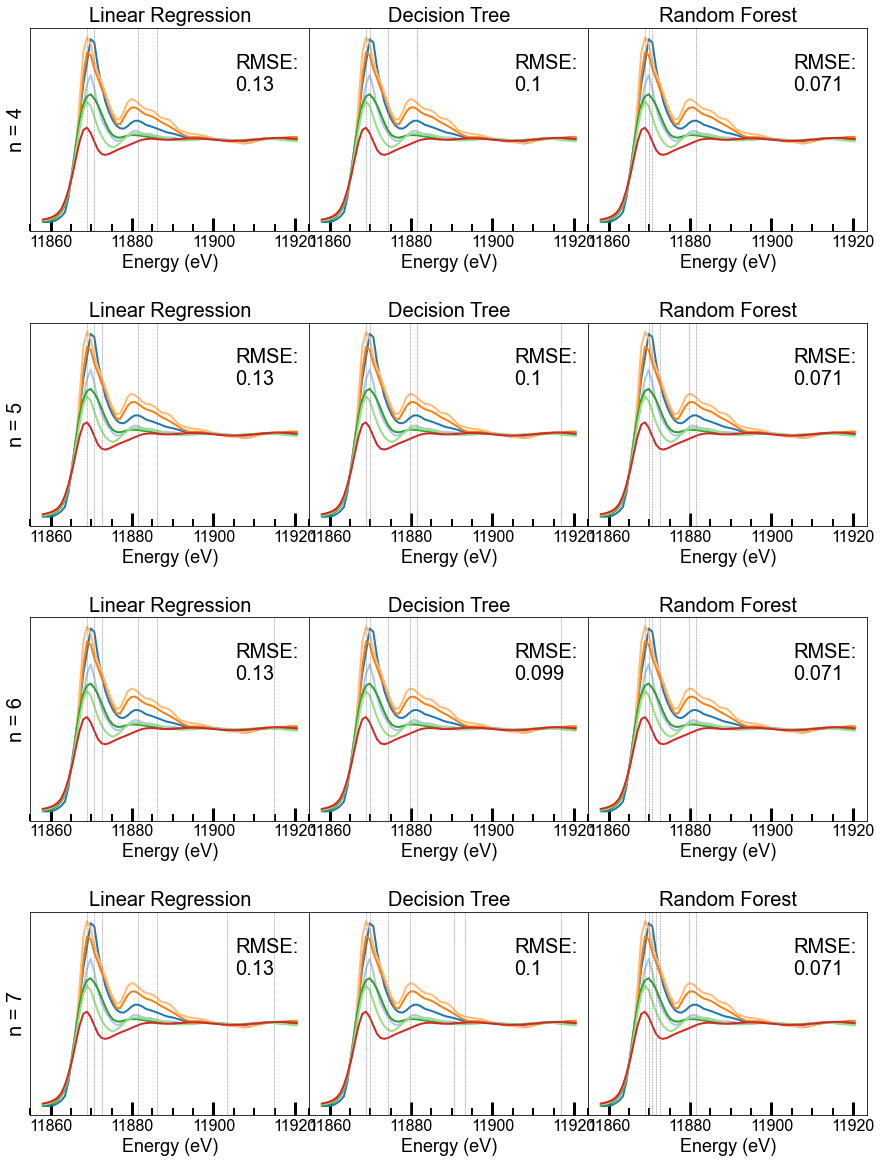

In [158]:
fig, axes = plt.subplots(figsize=(15, 20), nrows=len(n_points), ncols=len(models))
plt.subplots_adjust(wspace=0, hspace=0.45)

for i, npts in enumerate(n_points):
    row_axes = axes[i]
    for energy_pts, model, score, ax in zip(Epts[i], models, Scores[i], row_axes):
        if align_whiteline:
            diff = 15
            ticks = (5, 20)
        else:
            diff = 25
            ticks = (10, 20)
        visualize_energy_points((fig, ax), Energy, Aligned_Refs,
                                energy_pts, ticks=ticks, label=model)
        text = ax.text(np.max(Energy) - diff, np.max(Aligned_Refs)*0.8, f'RMSE:\n{-score:.2}',
                       ha="left", va="center", size=20)
    label = row_axes[0].set_ylabel(f'n = {npts}', fontsize=20)